In [14]:
import pandas as pd

# Load datasets
df1 = pd.read_csv("data/2021_to_2024_pre_election/all_votes.csv")
df2 = pd.read_csv("data/post_2024_06_09/all_votes.csv")

def compute_deviations(df, label):
    print(f"\n=== {label} ===")

    # Identify vote columns (everything that looks like a number)
    vote_cols = [c for c in df.columns if c.isdigit()]

    results = []

    # Group by party
    for party, group in df.groupby("member.group.short_label"):
        deviators_total = 0
        votes_total = 0

        for col in vote_cols:
            votes = group[col].dropna()
            if votes.empty:
                continue
            votes = votes[votes != "DID_NOT_VOTE"]

            # Determine party majority (mode)
            maj = votes.mode()
            if maj.empty:
                continue
            maj_vote = maj.iloc[0]

            # Count deviators (different from majority)
            deviators = (votes != maj_vote).sum()

            deviators_total += deviators
            votes_total += len(votes)

        share = deviators_total / votes_total if votes_total > 0 else 0
        results.append({
            "party": party,
            "total_votes": votes_total,
            "deviators": deviators_total,
            "share_deviators": round(share, 3)
        })

    res = pd.DataFrame(results).sort_values("share_deviators", ascending=False)
    print(res.to_string(index=False))

# Run for both datasets
compute_deviations(df1, "Pre-election (2021–2024)")
compute_deviations(df2, "Post-election (after 2024-06-09)")


=== Pre-election (2021–2024) ===
       party  total_votes  deviators  share_deviators
Non-attached        60013      19105            0.318
          ID        80164      21208            0.265
         ECR        91403      16903            0.185
     GUE/NGL        49638       7727            0.156
         EPP       239101      13855            0.058
       Renew       143606       7375            0.051
         S&D       189625       5208            0.027
  Greens/EFA       102211       2441            0.024

=== Post-election (after 2024-06-09) ===
              party  total_votes  deviators  share_deviators
       Non-attached         6218       2097            0.337
Patriots for Europe        18035       3342            0.185
                ECR        16780       2870            0.171
            GUE/NGL         9256       1391            0.150
                ESN         5604        586            0.105
                EPP        39325       2295            0.058
           

In [15]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Load datasets
df1 = pd.read_csv("data/2021_to_2024_pre_election/all_votes.csv")
df2 = pd.read_csv("data/post_2024_06_09/all_votes.csv")

def deviation_counts(df):
    vote_cols = [c for c in df.columns if c.isdigit()]
    results = []

    for party, group in df.groupby("member.group.short_label"):
        dev_total = 0
        votes_total = 0
        for col in vote_cols:
            votes = group[col].dropna()
            if votes.empty:
                continue
            votes = votes[votes != "DID_NOT_VOTE"]
            maj = votes.mode()
            if maj.empty:
                continue
            maj_vote = maj.iloc[0]
            dev_total += (votes != maj_vote).sum()
            votes_total += len(votes)
        results.append({"party": party, "deviators": dev_total, "total": votes_total})
    return pd.DataFrame(results).set_index("party")

# Compute pre and post
pre = deviation_counts(df1)
post = deviation_counts(df2)

# Merge and run z-tests
combined = pre.join(post, lsuffix="_pre", rsuffix="_post")
combined["p_value"] = None
combined["z_stat"] = None
combined["share_change"] = (combined["deviators_post"]/combined["total_post"]) - (combined["deviators_pre"]/combined["total_pre"])

for party, row in combined.iterrows():
    count = [row["deviators_pre"], row["deviators_post"]]
    nobs = [row["total_pre"], row["total_post"]]
    z, p = proportions_ztest(count, nobs)
    combined.at[party, "z_stat"] = z
    combined.at[party, "p_value"] = p

# Significance flag
combined["significant"] = combined["p_value"] < 0.05

# Round and show
print(combined[["deviators_pre","total_pre","deviators_post","total_post","share_change","p_value","significant"]].round(4))

              deviators_pre  total_pre  deviators_post  total_post   
party                                                                
ECR                   16903      91403          2870.0     16780.0  \
EPP                   13855     239101          2295.0     39325.0   
GUE/NGL                7727      49638          1391.0      9256.0   
Greens/EFA             2441     102211           482.0     11571.0   
ID                    21208      80164             NaN         NaN   
Non-attached          19105      60013          2097.0      6218.0   
Renew                  7375     143606           844.0     15942.0   
S&D                    5208     189625           974.0     28650.0   

              share_change   p_value  significant  
party                                              
ECR                -0.0139  0.000019         True  
EPP                 0.0004  0.745062        False  
GUE/NGL            -0.0054  0.188463        False  
Greens/EFA          0.0178       0.0   

              share_pre  share_post  share_change  p_value  significant
party                                                                  
ECR              0.1849      0.1710       -0.0139   0.0000         True
EPP              0.0579      0.0584        0.0004   0.7451        False
GUE/NGL          0.1557      0.1503       -0.0054   0.1885        False
Greens/EFA       0.0239      0.0417        0.0178   0.0000         True
ID               0.2646         NaN           NaN      NaN        False
Non-attached     0.3183      0.3372        0.0189   0.0024         True
Renew            0.0514      0.0529        0.0016   0.3900        False
S&D              0.0275      0.0340        0.0065   0.0000         True


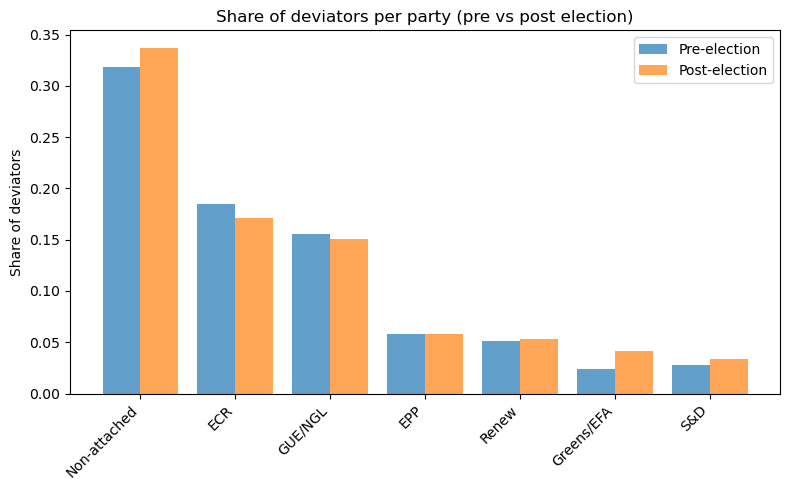

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

# --- Load ---
df1 = pd.read_csv("data/2021_to_2024_pre_election/all_votes.csv")
df2 = pd.read_csv("data/post_2024_06_09/all_votes.csv")

# --- Function to compute total deviators and votes per party ---
def deviation_counts(df):
    vote_cols = [c for c in df.columns if c.isdigit()]
    results = []
    for party, group in df.groupby("member.group.short_label"):
        dev_total, votes_total = 0, 0
        for col in vote_cols:
            votes = group[col].dropna()
            votes = votes[votes != "DID_NOT_VOTE"]
            if votes.empty: continue
            maj = votes.mode()
            if maj.empty: continue
            maj_vote = maj.iloc[0]
            dev_total += (votes != maj_vote).sum()
            votes_total += len(votes)
        results.append({"party": party, "deviators": dev_total, "total": votes_total})
    return pd.DataFrame(results).set_index("party")

# --- Compute ---
pre = deviation_counts(df1)
post = deviation_counts(df2)

# Merge + z-test
combined = pre.join(post, lsuffix="_pre", rsuffix="_post")
combined["share_pre"]  = combined["deviators_pre"] / combined["total_pre"]
combined["share_post"] = combined["deviators_post"] / combined["total_post"]
combined["share_change"] = combined["share_post"] - combined["share_pre"]

# Run significance test
p_values, z_stats = [], []
for i, row in combined.iterrows():
    if pd.isna(row["deviators_post"]):  # skip missing
        p_values.append(None); z_stats.append(None); continue
    count = [row["deviators_pre"], row["deviators_post"]]
    nobs  = [row["total_pre"], row["total_post"]]
    z, p = proportions_ztest(count, nobs)
    p_values.append(p); z_stats.append(z)
combined["p_value"] = p_values
combined["significant"] = combined["p_value"] < 0.05

# --- Print summary ---
print(combined[["share_pre","share_post","share_change","p_value","significant"]].round(4))

# --- Graph ---
combined_plot = combined.dropna(subset=["share_pre","share_post"]).sort_values("share_post", ascending=False)

fig, ax = plt.subplots(figsize=(8,5))
x = range(len(combined_plot))

ax.bar(x, combined_plot["share_pre"], width=0.4, label="Pre-election", color="#1f77b4", alpha=0.7)
ax.bar([i + 0.4 for i in x], combined_plot["share_post"], width=0.4, label="Post-election", color="#ff7f0e", alpha=0.7)

ax.set_xticks([i + 0.2 for i in x])
ax.set_xticklabels(combined_plot.index, rotation=45, ha="right")
ax.set_ylabel("Share of deviators")
ax.set_title("Share of deviators per party (pre vs post election)")
ax.legend()
plt.tight_layout()
plt.show()